# Example Notebook

This notebook will provide a few quick examples of how the `icepack` package may be used. Please direct any questions or comments to `gpayne1654@uvic.ca`.

To start, we'll import `xarray` to read in the NetCDF data and also import `matplotlib` for plotting. `numpy` will also prove useful.

In [1]:
import xarray as xr
import numpy as np

# for plotting
import matplotlib.pyplot as plt

Let's import some OSI-SAF sea ice concentration (SIC) data and land mask:

In [2]:
mask = xr.open_dataset("~/sea_ice/data/masks/land_all.nc")
data_sic = xr.open_dataset("~/sea_ice/data/obs/OSI-450-a/sic/1x1/ice_conc_sh_1x1-250_cdr-v3p0_197901-202012_tint.nc")

print(data_sic['ice_conc'])

<xarray.DataArray 'ice_conc' (time: 504, lat: 180, lon: 360)> Size: 131MB
[32659200 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 4kB 1979-01-16T12:00:00 ... 2020-12-16T12:...
  * lon      (lon) float64 3kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Attributes:
    standard_name:        sea_ice_area_fraction
    long_name:            fully filtered concentration of sea ice using atmos...
    units:                %
    ancillary_variables:  total_standard_uncertainty status_flag
    comment:              this field is the primary sea ice concentration est...


### Calculating Sea Ice Extent

Next, let's compute sea ice extent in the Southern Hemisphere at each time step using `icepack.analysis`'s `get_iceextent` function, and then plot it. If `icepack` is not in your working directory, you may need to add its location to `PATH` in order to be able to import it.

IMPORTANT: `get_iceextent` assumes your data are on a regular 1x1 grid in calculating SIE. Other grids are currently unsupported.

In [3]:
from icepack.analysis import get_iceextent

data_sie = get_iceextent(data_sic,                          # the sea ice concentration data
                         mask=mask,                         # the land mask to be applied
                         mask_id=np.nan,                    # the value in mask that indicates masked grid cells.
                         lat_bounds=(-90,0),                # restrict calculation to SH. (Alternatively could also just use a mask equivalent)
                         ensemble=None,                     # this dataset has no ensembles. If it did, we could specify 'mean' or select a specific ensemble member.
                         multiply_input_by=1e-2,            # the dataset's SIC has units of percent, so we multiply it by 0.01 to convert it to decimal before calculating SIE. (The function assumes decimal)
                         multiply_output_by=1e-12,          # Once the SIE has been calculated, multiply it by 1e-12 to convert to units of millions of sq. km. (1e-12 is default)
                         dslabels={'lat':'lat',             
                                 'lon':'lon',               # The labels of the dataset's variables and dimensions
                                 'time':'time',             #  (if any particular variable/dim isn't specified in this dict, the function will instead try to auto-detect its string label,
                                 'sic':'ice_conc',          #  based on common names they often have.)
                                 'ens':None})

print(data_sie)

<xarray.Dataset> Size: 8kB
Dimensions:  (time: 504)
Coordinates:
  * time     (time) datetime64[ns] 4kB 1979-01-16T12:00:00 ... 2020-12-16T12:...
Data variables:
    SIE      (time) float64 4kB 5.714 3.025 4.266 8.003 ... 18.36 16.38 11.89


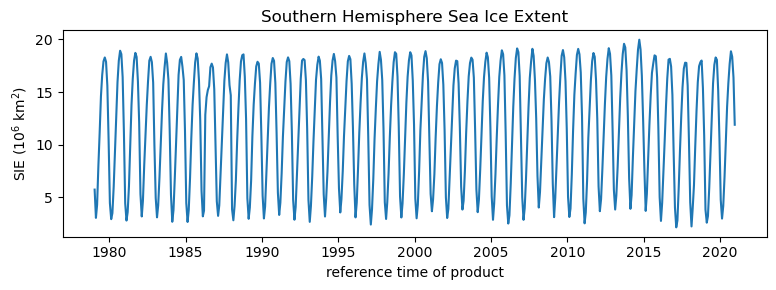

In [41]:
# PLOT

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,3))
data_sie['SIE'].plot(ax=ax)
ax.set_title('Southern Hemisphere Sea Ice Extent')
ax.set_ylabel(r'SIE ($10^6$ km$^2$)')

plt.tight_layout()
plt.show()

If we want a climatology (relative to the dataset's temporal coverage), we can use xarrays `groupby` and `mean` functionalities:

In [42]:
data_sie_climatology = data_sie.groupby('time.month').mean('time')

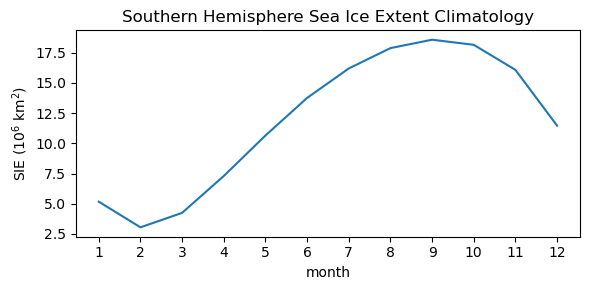

In [43]:
# PLOT

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(6,3))
data_sie_climatology['SIE'].plot(ax=ax)
ax.set_title('Southern Hemisphere Sea Ice Extent Climatology')
ax.set_xticks(np.arange(1,12+1,1))
ax.set_ylabel(r'SIE ($10^6$ km$^2$)')

plt.tight_layout()
plt.show()

And now we can compute anomalies by subtracting the climatology:

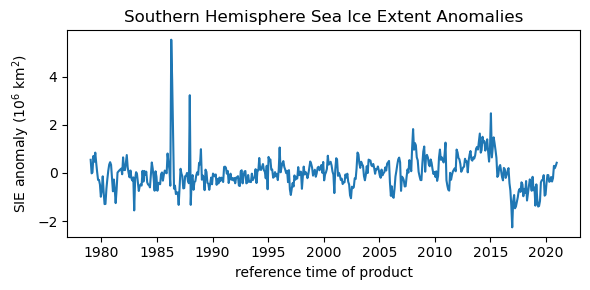

In [44]:
# compute anomalies
data_sie_anomalies = data_sie.groupby('time.month') - data_sie_climatology

# plot
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(6,3))

data_sie_anomalies['SIE'].plot(ax=ax)
ax.set_title('Southern Hemisphere Sea Ice Extent Anomalies')
ax.set_ylabel(r'SIE anomaly ($10^6$ km$^2$)')

plt.tight_layout()
plt.show()

The equivalent function for calculating sea ice area (SIA) instead of extent is `get_icearea`.
See the docstrings of these functions for more details.

## Calculating Skill (Anomaly Correlations) and Skill Plots

First, let's import some data from an initialized model. In my case, I have a separate `.nc` file for each initialization month.

In [7]:
import glob

# Import data into a list
paths = sorted(glob.glob("/home/rrp000/sea_ice/data/model/CanESM5/v0/init/sic/1x1/*.nc"))
modeldata_sic = [xr.open_dataset(path) for path in paths]

print(modeldata_sic[0])

<xarray.Dataset> Size: 1GB
Dimensions:    (ensemble: 10, time: 480, bnds: 2, lat: 180, lon: 360)
Coordinates:
  * time       (time) object 4kB 1981-01-16 12:00:00 ... 2020-12-16 12:00:00
  * lon        (lon) float64 3kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * lat        (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Dimensions without coordinates: ensemble, bnds
Data variables:
    time_bnds  (ensemble, time, bnds) object 77kB ...
    siconc     (ensemble, time, lat, lon) float32 1GB ...
Attributes: (12/61)
    CDI:                         Climate Data Interface version 2.4.1 (https:...
    Conventions:                 CF-1.7 CMIP-6.2
    source:                      CanESM5 (2019): \naerosol: interactive\natmo...
    institution:                 Canadian Centre for Climate Modelling and An...
    CCCma_model_hash:            3309e8e3d85d70587fac594374ce4e8d33327493
    CCCma_parent_runid:          d2g-asm-e01
    ...                          ...
    vari

Calculate sea ice extent. Notice that a lot of the parameters need not be specified in this case, as they either have useful defaults or auto-detect an appropriate value. As always, check the docstring for more information.

In [8]:
modeldata_sie = [get_iceextent(modeldata,
                               mask,
                               lat_bounds=(-90,0),
                               ensemble='mean',
                               multiply_input_by=1e-2) for modeldata in modeldata_sic]

Now let's calculate the anomaly correlation of our model with the previous OSI-SAF data as a function of lead time and target month.

In [9]:
from icepack.skill import get_skillmatrix

skill_model = get_skillmatrix(data_sie,
                                modeldata_sie,
                                daterange=(1985,2015),
                                significance_test=False)

print(skill_model)

[[ 0.94243827  0.83626653  0.76889293  0.58772827  0.59913644  0.58052133
   0.52160552  0.50887668  0.47494005  0.28282257  0.37275541 -0.08860524]
 [ 0.62729181  0.88651858  0.76534557  0.54753421  0.57202328  0.70698985
   0.52065971  0.49694708  0.47075505  0.30398133  0.37048982 -0.08488439]
 [ 0.50193533  0.23793051  0.84569428  0.49927381  0.47351461  0.52515478
   0.51388535  0.48721013  0.48451537  0.3950173   0.44523294  0.02572208]
 [ 0.57648347  0.26476577  0.46521031  0.38440915  0.27197936  0.43732912
   0.52819693  0.54164447  0.56490279  0.47793001  0.60120812  0.18151593]
 [ 0.70737143  0.16449453  0.34497499  0.26030632  0.33501305  0.61927418
   0.73246011  0.54023348  0.5954674   0.48346266  0.50995999  0.07129821]
 [ 0.61330672  0.12447604  0.28922324  0.13331804  0.30172231  0.63406172
   0.68509398  0.49773233  0.52910958  0.49237426  0.55903593  0.18158999]
 [ 0.57616448  0.10492529  0.31453455  0.13944681  0.22680394  0.38821411
   0.85880005  0.59958295  0.605

We can easily plot this skill matrix on an existing axis with `icepack`'s `splot` module.

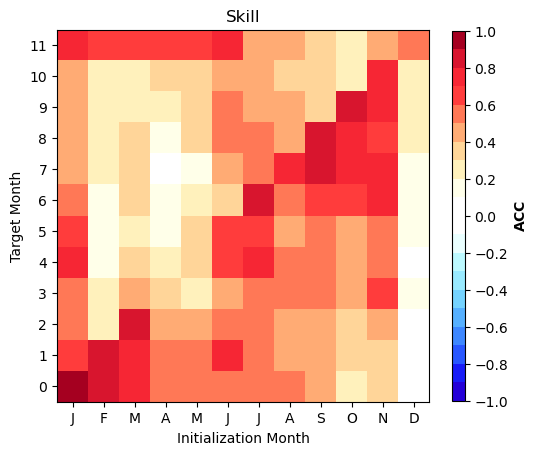

In [10]:
from icepack.splot import plot_skillmatrix

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(6,6))
skill_plot = plot_skillmatrix(ax=ax, skill_matrix=skill_model)
ax.set_xlabel("Initialization Month")
ax.set_ylabel("Target Month")

# colour bar
skill_plot.set_clim([-1.,1.])
cticks = np.linspace(-1.,1.,11)
cbar = plt.colorbar(skill_plot,ax=ax,aspect=30,shrink=.8,ticks=cticks,location='right',pad=0.05,label=r"$\mathbf{ACC}$")

plt.show()

In order to plot skill as a function of lead time and target month, rather than target month and initialization month, we can sort the SIE data by lead time and reapply the `get_skillmatrix` function.

In [11]:
# Let's sort the data by lead time instead of initialization month
modeldata_sie_bylead = [xr.merge([modeldata_sie[im-1].where((modeldata_sie[im-1]['time.month']-im)%12==lead,drop=True) for im in np.arange(1,13)]) for lead in range(12)]

skill_model = get_skillmatrix(data_sie,
                                modeldata_sie_bylead,
                                daterange=(1985,2015),
                                significance_test=False)

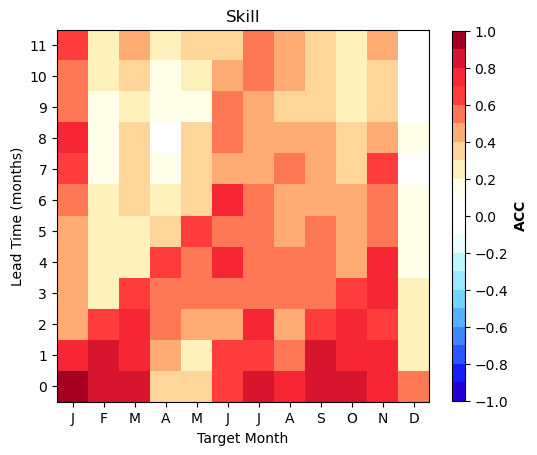

In [12]:
from icepack.splot import plot_skillmatrix

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(6,6))
skill_plot = plot_skillmatrix(ax=ax, skill_matrix=skill_model)
ax.set_xlabel("Target Month")

# colour bar
skill_plot.set_clim([-1.,1.])
cticks = np.linspace(-1.,1.,11)
cbar = plt.colorbar(skill_plot,ax=ax,aspect=30,shrink=.8,ticks=cticks,location='right',pad=0.05,label=r"$\mathbf{ACC}$")

plt.show()

Finally, let's introduce statistical significance based on a bootstrap procedure:

In [13]:
skill_model, sig_model = get_skillmatrix(data_sie,
                                modeldata_sie_bylead,
                                daterange=(1985,2015),
                                significance_test=True,
                                Nb = 1000,
                                significance_level = 95)

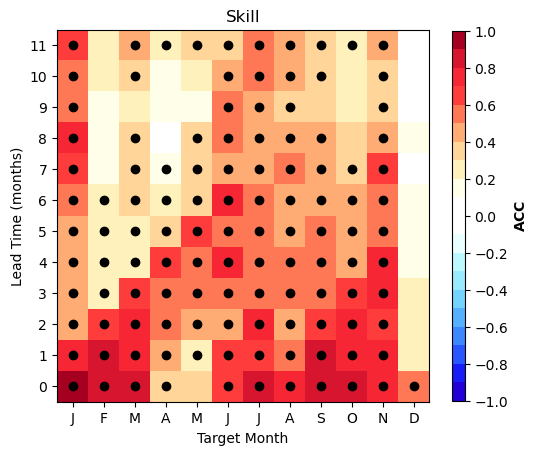

In [14]:
from icepack.splot import plot_skillmatrix

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(6,6))
skill_plot = plot_skillmatrix(ax=ax, skill_matrix=skill_model)

# plot statistical significance markers
for tm in np.arange(1,12+1,1):
    for lead in np.arange(11+1):
        if sig_model[tm-1][lead]:
            ax.plot(lead,tm-1,'o',color='black')

# colour bar
skill_plot.set_clim([-1.,1.])
cticks = np.linspace(-1.,1.,11)
cbar = plt.colorbar(skill_plot,ax=ax,aspect=30,shrink=.8,ticks=cticks,location='right',pad=0.05,label=r"$\mathbf{ACC}$")

ax.set_xlabel("Target Month")
plt.show()